## Quantum Kitchen Sinks by Wilson et al.[1]

Put simply quantum kitchens sinks(QKS) algorithm allows us to extract high dimensional non-linear transformation of the dataset using a quantum computer. Sometimes it may be the case that, datasets that require non-linear decision boundaries to discriminate, might be solved by less complex methods in higher dimensions$\dagger$. We can use the high dimensional feature vectors thus created as input to a classical ML algorithm to improve its performance over its purely classical counterpart. Since we are only interested in demonstrating how the feature vectors from QKS give a performance boost, we will use only linear methods in the classical part of the algorithm. This is because we expect the QKS process to be highly non-linear and we run the risk of using a powerful non-linear classical step that will give us good results despite the non-linear quantum transformations. Wilson et al. refer to this as the *Linear Baseline Rule*. Hence we will use *Logistic Regression* as our linear baseline. We will compare the accuracy of classification using logistic regression with and without the embeddings from QKS.


### Algorithm:
We will be using the (3,5)-MNIST dataset for this demnstration. The dataset consists of a 784-dimensional handwritten examples; with two classes (-1, +1) for 3 and 5 respectively. 

1. *Standardize the dataset*
2.  Use logistic regression to construct a linear baseline.
3.  Use the QKS algorithm with the standardized dataset to obtain feature vectors.
4.  Use logistic regression with the feature vectors created above to check the performace.

### QKS algorithm:
Given an example from the dataset we want to encode this in the quantum circuit parameters. We specifically choose the angles of rotation in the quantum circuit of our choice. We then measure the qubits in the Z-basis and the results of the measurements are a part of our feature vector. Since we are interested in high dimensional feature vectors of our dataset, we have two choices either use the quantum circuit with a large number of qubits and the qubits are highly entangled or sample various circuits. For example our MNIST dataset has 784 dimensional vector, a high dimensional feature vectors of the size of 2000-dimensions would need atleast 2000 qubits using the former method. This type of highly entangled quantum circuit with sufficinet depth with reasonable error rates are difficult in the NISQ era, instead we take a small circuit and create multiple parameter sets from the same example, the measurements from each of our quantum circuits forms a part of the feature vector for that example (called episodes). We use a two qubit quantum circuit, with two parameters. Each example is split into two and we derive the parameters from these.

Given a dataset $\{y_i, u_i\}_{i=1..m}$ of $m$ points where $u_i \in \mathbb{R}^p$ and a set of $E$ feature vectors derived from $u$, also called *episodes*[1].
$$\Omega_e \in \mathbb{R}^{q \times p}; \beta_e \in \mathbb{R}^q$$
$$\theta_{i, e} = \Omega_eu_i + \beta_e$$. *q* is the number of parameters in our ansatz, which in this case is 2.
$\theta_{i,e}$ are the parameters for the *i-*th example for its *e-*th episode. We simulate the ansatz for each of the $\theta_{i,e}$ thus forming $q \times E$ dimensional feature vector for each example. We will use logistic regression to classify these feature vector and compare performance. 


$\dagger$: for a much better explanation of this phenomenon please refer to a good ML text like Muphy or Bishop and look up kernel methods.

In [1]:
from cirq.contrib.svg import SVGCircuit
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from mnist import MNISTData

import scipy
import cirq
import numpy as np

seed = 42
np.random.seed(seed)

In [199]:
mnist_data = MNISTData(seed)
X_train, X_test, y_train, y_test = mnist_data.get_three_five_test_train_split()
train_indices = np.random.randint(0, X_train.shape[0], 1000)
test_indices = np.random.randint(0, X_test.shape[0], 100)

In [219]:
X_tr = X_train[train_indices]
y_tr = y_train[train_indices]
X_te = X_test[test_indices]
y_te = y_test[test_indices]
print(X_tr.shape, X_te.shape)

(1000, 784) (100, 784)


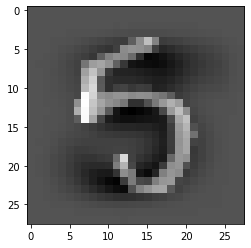

In [220]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure
plt.imshow(X_tr[0].reshape(28,28), cmap='gray')
plt.show()

## Establish Linear Baseline

We will use logistic regression to classify 0 and 1 in MNIST dataset to establish the baseline accuracy with a linear model, i.e logistic regression, so that we have a metric to beat.

In [221]:
clf = LogisticRegression(random_state=seed, max_iter=10000).fit(X_tr, y_tr)
# determine accuracy
clf.score(X_te, y_te)

0.95

In [222]:
class TwoQubitMnistQks:
    def __init__(self, X_train, y_train, X_test, y_test, repetitions=1, episodes=8900, stddev=0.05):
        self.qubits = cirq.LineQubit.range(2)
        # the number of qubits
        self.q = 2
        self.p = X_train.shape[1]
        self.r = self.p/self.q
        self.E = episodes
        self.X_train = X_train
        self.y_train = y_train
        self.y_test = y_test
        self.X_test = X_test
        self.stddev = stddev
        self.repetitions = repetitions
        # mask = E x p x q
        mask = np.ones((self.E, self.p, self.q))
        # this effectively splits the datapoint into two parts
        # along a horizontal axis, with the top part for the
        # first qubit parameter and the bottom one for the
        # second
        mask[:, :int(self.r), 0], mask[:, int(self.r):, 1] = 0.0, 0.0
        self.mask = mask
    
    def _get_ansatz(self, theta, draw=False):
        circuit = cirq.Circuit()
        circuit.append(cirq.rx(theta[0])(self.qubits[0]))
        circuit.append(cirq.rx(theta[1])(self.qubits[1]))
        circuit.append(cirq.CNOT(self.qubits[0], self.qubits[1]))
        circuit.append(cirq.measure(self.qubits[0]))
        circuit.append(cirq.measure(self.qubits[1]))
        
        if draw:
            SVGCircuit(circuit)    
        return circuit
    
    def _get_meas(self, theta):
        circuit = self._get_ansatz(theta)
        result = cirq.Simulator().run(circuit, repetitions=1)
        result = np.array([np.sum(result.measurements['0'])/self.repetitions,
                           np.sum(result.measurements['1'])/self.repetitions])
        return result
    
    def _get_omega_and_beta(self):
        # omega_e = (E x p x q)
        omega_e = np.random.normal(0.0, self.stddev, (self.E, self.p,  self.q))
        omega = self.mask * omega_e
        beta = np.random.uniform(0.0, 2 * np.pi, (self.E, self.q))
        return omega, beta
    
    def _get_params(self, data):
        omega, beta = self._get_omega_and_beta()
        # params = (n x E x q)
        params = data.dot(omega) + beta
        return params
    
    def get_embeddings(self):
        params_tr = self._get_params(self.X_train)
        embeddings_tr = np.zeros((params_tr.shape[0], self.q * self.E))
        
        params_te = self._get_params(self.X_test)
        embeddings_te = np.zeros((params_te.shape[0], self.q * self.E))
        
        for idx, param in enumerate(params_tr):
            if idx % 10 == 0:
                print("Getting train embeddings for batch: ", idx)
            for jdx, theta in enumerate(param):
                meas = self._get_meas(theta)
                embeddings_tr[idx][jdx] += meas[0]
                embeddings_tr[idx][jdx + self.E] += meas[1]
        
        for idx, param in enumerate(params_te):
            if idx % 10 == 0:
                print("Getting test embeddings for batch: ", idx)
            for jdx, theta in enumerate(param):
                meas = self._get_meas(theta)
                embeddings_te[idx][jdx] += meas[0]
                embeddings_te[idx][jdx + self.E] += meas[1]
        return embeddings_tr, embeddings_te

In [223]:
twoQubitMnistQks = TwoQubitMnistQks(X_tr, y_tr, X_te, y_te, episodes=1000, stddev=1.0)

In [224]:
twoQubitMnistQks._get_ansatz([np.pi, np.pi], draw=True)

0: ───Rx(π)───@───M───
              │
1: ───Rx(π)───X───M───

In [225]:
embeddings_tr, embeddings_te = twoQubitMnistQks.get_embeddings()

Getting train embeddings for batch:  0
Getting train embeddings for batch:  10
Getting train embeddings for batch:  20
Getting train embeddings for batch:  30
Getting train embeddings for batch:  40
Getting train embeddings for batch:  50
Getting train embeddings for batch:  60
Getting train embeddings for batch:  70
Getting train embeddings for batch:  80
Getting train embeddings for batch:  90
Getting train embeddings for batch:  100
Getting train embeddings for batch:  110
Getting train embeddings for batch:  120
Getting train embeddings for batch:  130
Getting train embeddings for batch:  140
Getting train embeddings for batch:  150
Getting train embeddings for batch:  160
Getting train embeddings for batch:  170
Getting train embeddings for batch:  180
Getting train embeddings for batch:  190
Getting train embeddings for batch:  200
Getting train embeddings for batch:  210
Getting train embeddings for batch:  220
Getting train embeddings for batch:  230
Getting train embeddings fo

In [227]:
clf = LogisticRegression(random_state=seed, max_iter=1000).fit(embeddings_tr, y_tr)
clf.score(embeddings_te, y_te)

0.97


### References:

[1] Wilson, C.M., Otterbach, J.S., Tezak, N., Smith, R.S., Polloreno, A.M., Karalekas, P.J., Heidel, S., Alam, M.S., Crooks, G.E. and da Silva, M.P., 2018. Quantum kitchen sinks: An algorithm for machine learning on near-term quantum computers. arXiv preprint arXiv:1806.08321.